# Assignment 8
## Learning Outcomes:
This assignment introduces the use of discrete variables in regression analysis. Task 1 will use discrete variables as explanatory variables, in Task 2 we will use discrete variables as response variables and introduce logistic regression. 

## Data set 
Throught the assignment you will use the full possum.csv data set.  
The data set includes measures from 104 possums that were caught in New Zealand in a field study. 
Variables: 
-	site: The site number where the possum was trapped.
-	pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
-	sex: Gender, either m (male) or f (female).
-	age: Age in years
-	headL: Head length, in mm.
-	skullW: Skull width, in mm.
-	totalL: Total length, in cm.
-	tailL: Tail length, in cm.

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.optimize as so
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [3]:
df = pd.read_csv('possum.csv')
df

,site,pop,sex,age,headL,skullW,totalL,tailL
0,1,Vic,m,8,94.1,60.4,89.0,36.0
1,1,Vic,f,6,92.5,57.6,91.5,36.5
2,1,Vic,f,6,94.0,60.0,95.5,39.0
3,1,Vic,f,6,93.2,57.1,92.0,38.0
4,1,Vic,f,2,91.5,56.3,85.5,36.0
...,...,...,...,...,...,...,...,...
99,7,other,m,1,89.5,56.0,81.5,36.5
100,7,other,m,1,88.6,54.7,82.5,39.0
101,7,other,f,6,92.4,55.0,89.0,38.0
102,7,other,m,4,91.5,55.2,82.5,36.5


In [90]:
#Required previous functions
def multRegPredict(b,D,xname):
    yp = np.ones(len(D.index)) * b[0]
    
    for i in range(len(xname)):          
        yp = yp + D[xname[i]] * b[i + 1]
    return yp 

def multRegLossRSS(b, D, y, xname):
    predY = multRegPredict(b, D, xname)
    res = y-predY
    rss = sum(res ** 2)
    grad = np.zeros(len(b))
    grad[0] = -2 * np.sum(res)
    
    for i in range(len(xname)):
        grad[i + 1] = -2 * np.sum(D[xname[i]] * res)
    return (rss,grad)

def multRegFit(D, y, xname):
    N = len(xname)
    b0 = np.zeros((N + 1, 1))
    RES = so.minimize(multRegLossRSS, b0, args=(D, y, xname), jac=True)
    
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    
    b = RES.x
    res = y - np.mean(y)
    TSS = sum(res ** 2)
    RSS, deriv = multRegLossRSS(b, D, y, xname)
    R2 = 1 - RSS / TSS 
    return (R2, b)

def leaveOneOutCV(x, y, fitfcn = multRegFit, args = (), predictfcn = multRegPredict):
    N = len(x) #Number of observations 
    yp = np.zeros(N)
    ind = np.arange(N)
    
    for i in range(N):
        r, b, ax = fitfcn(x[ind != i], y[ind != i], args, fig=False)
        yp[i] = predictfcn(b, x[i])
    
    TSS = sum((y - y.mean()) ** 2)
    RSScv = sum((y - yp) ** 2)
    R2cv = 1 - RSScv / TSS

    r, b, ax = fitfcn(x, y, args)
    yf = predictfcn(b, x)
    RSS = sum((y - yf) ** 2)
    R2 = 1 - RSS / TSS
    return R2cv, R2

def bootstrapReg(D, y, args, fitfcn, numIter=1000):
    r2, b = fitfcn(D, y, args)
    numParams = len(b)
    N = len(D.index)
    ind  = np.arange(N)
    stats = np.zeros((numIter, numParams))
    
    for i in range(numIter):
        sample = np.random.choice(ind, N)
        r2, stats[i, :] = fitfcn(D.iloc[sample], y[sample], args)
    return stats

def confidenceInt(data, perc):
    Int = (np.percentile(data, (100 - perc) / 2), np.percentile(data, 100 - (100 - perc) / 2))
    return Int

## Task 1: Discrete predictor variables

### Question 1 (5 pt)
Load the data set possum.csv. 
Generate 3 new columns in the data frame: 
- bodyL: The length of the main body (totalL - tailL) 
- popI:  Population identifier, 0: if pop is 'other', 1: if pop is 'Vic'
- sexI:  Sex indentifier, 0: if sex is 'm', 1: if sex is 'f'
Use your function multRegression to run a regression analysis of bodyL (response variable) against sexI (explanatory variable). Make a plot (with labeled axes) that show sex on the x-axis and body length on the y axis. Add the prediction line from the regression. 

R2: 0.02895861728871396, b: [49.56885246  1.23347312]


<AxesSubplot:xlabel='sexl', ylabel='bodyL'>

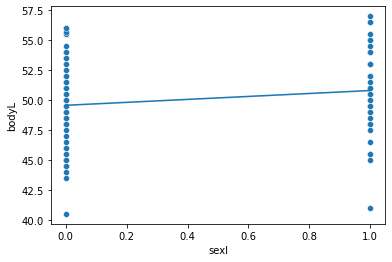

In [22]:
df['bodyL'] = df['totalL'] - df['tailL']
df['popl'] = np.double(df['pop'] == 'Vic')
df['sexl'] = np.double(df['sex'] == 'f')
df

#multiRegression part
R2, b = multRegFit(df, df['bodyL'].values, ['sexl'])
print(f'R2: {R2}, b: {b}')

yp = multRegPredict(b, df, ['sexl'])
sns.scatterplot(x = 'sexl', y = 'bodyL', data = df)
sns.lineplot(x = 'sexl', y = yp, data = df)

Figure 1: Scatter plot of the variables 'sexl' and 'bodyL' with the prediction line added

### Question 2 (10pt)
Use boostrap to estimate a 95% confidence interval on the regression parameter of sex as a explanatory variable for body length. Report the interval. Can you reject the null-hypothesis that body length in possums does not differ between the sexes?  

In [43]:
bStrap = bootstrapReg(df, df['bodyL'], ['sexl'], fitfcn = multRegFit, numIter = 100)
cInt = confidenceInt(bStrap[:, 1], 95)
print(f'The interval is: {cInt}')

The interval is: (-0.1749948524365236, 2.355183987488651)


Written Answer: In this case we cannot reject the null hypothesis that body length in possums does not differ between the sexes because the confidence interval contains 0.

### Question 3 (10pt)
Make a scatter plot of age (x-axis) against body length (y-axis), with male and female possums shown in different colors. 
You can do this by plotting two scatter plots sequentially - each time selecting either male or female possums. The second one will simply add points in a different color to the first plot.  

Estimate a multiple regression model that explains bodyL as a function of age and sex. What is the R2-value? 

Get the predicted values from the regression, and plot the predicted values in the same graph seperately for male and female possums. 

R2: 0.08543037213506366


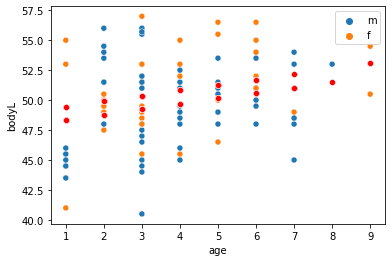

In [40]:
sns.scatterplot(x = 'age', y = 'bodyL', hue = 'sex', data = df)
R2, b = multRegFit(df, df['bodyL'].values, ['age', 'sexl'])
yp = multRegPredict(b, df, ['age', 'sexl'])
sns.scatterplot(x = 'age', y = yp, data = df, color = 'r')
print(f'R2: {R2}')

Figure 2: Scatter plot of 'age' and 'bodyL' between both male and female possums

### Question 4 (7pt)
Run a bootstrap analysis on the bodyL ~ age + sexI regression model. Report the 95% confidence interval for the regression parameters of sex and age on body length. Is the effect of age onto body length significant in the context of the model? How about the relationship between sex and body length?  


In [44]:
bStrap = bootstrapReg(df, df['bodyL'], ['age', 'sexl'], fitfcn = multRegFit, numIter = 100)
cInt1 = confidenceInt(bStrap[:, 1], 95)
cInt2 = confidenceInt(bStrap[:, 2], 95)
print(f'The age interval is: {cInt1} and the sexl is: {cInt2}')

The age interval is: (0.14914859666626876, 0.9442370725610868) and the sexl is: (-0.1666270457125727, 2.0285510821939625)


Written Answer: The effect of age on body length is not significant since the interval doesn't contain 0, and the relationship between sex and body length is significant since the interval does contain 0.

### Question 5 (10pt)
Estimate a multiple regression model that explains bodyL as a function of age and population (Vic vs. other). What is the R2-value? Make a scatter plot like for Question 3, but this time splitting the data for the two populations, rather than based on sex. Which of the two population (Vic or other) is larger? How do you interpret the value of the regression coefficient for popI? 

R2: 0.08543037213506366


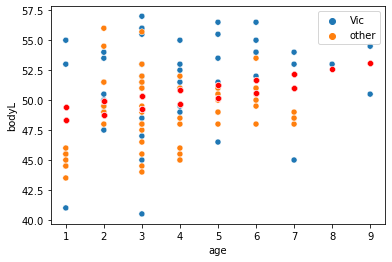

In [47]:
R2, b = multRegFit(df, df['bodyL'].values, ['age', 'sexl'])
sns.scatterplot(x = 'age', y = 'bodyL', hue = 'pop', data = df)
yp = multRegPredict(b, df, ['age', 'popl'])
sns.scatterplot(x = 'age', y = yp, data = df, color = 'r')
print(f'R2: {R2}')

Figure 3: Scatter plot of 'age' and 'bodyL' with the separation of the data by 'pop'

Written Answer: The larger population is definitely the 'other' population since it takes up a majority of the scatter plot.  The regression coefficient for 'popl' of ~0.085 means that it doesn't explain the models variability very well.

### Question 6 (8pt)
Run a bootstrap analysis on the bodyL ~ age + popI regression model. Report the 95% confidence interval for the regression parameters of popI and age on body length. Is the effect of age onto body length significant in the context of the model? How about the relationship between population and body length? 


In [45]:
bStrap = bootstrapReg(df, df['bodyL'], ['age', 'popl'], fitfcn = multRegFit, numIter = 100)
cInt1 = confidenceInt(bStrap[:, 1], 95)
cInt2 = confidenceInt(bStrap[:, 2], 95)
print(f'The age interval is: {cInt1} and the popl is: {cInt2}')

The age interval is: (0.13124259896725177, 0.7507449849515097) and the popl is: (1.0746561070407405, 3.683714094799123)


Written Answer: The effect of age onto body length is null since the interval does not include 0, and the relationship between population and body length is also null since the interval also doesn't include 0.

## Task 2: Discrete response variable
In this task we will investigate regression models in which the response variable is a discrete, dichotomous variable. 
### Question 1: Logistic Function (10pt)
Starting with your function for multRegPredict, write a function logisticRegPredict(b,D,xname). As inputs it should take the 
- b: np-array of regression coefficients (the first one being the intercept)
- D: Data frame
- xname: a list of column names (in D) that are being used as regressors. 

The function should first calculate a = b[0] + b[1] * D[xname[0]] + b[2] * D[xname[1]] 
and then return the logistic function of a. 

Then make a Data frame with a single column with the values from -4 to 4 (in small steps). Plot the logistic function for the parameter values: 
- b = [0,0]
- b = [0,1]
- b = [0,2]
- b = [0,-2]

What happens as the slope value changes? 

Then plot the logistic function for the parameter values: 
- b = [0,2]
- b = [1,2]
- b = [2,2]
- b = [-2,2]

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5? 



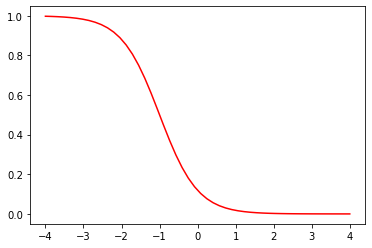

In [75]:
def logisticRegPredict(b, D, xname):
    an = np.ones(len(D.index)) * b[0]
    
    for i in range(len(xname)):          
        an = an + b[i + 1] * D[xname[i]]
        
    pn = 1/(1 + np.exp(an))
    return pn

#Function testing **just using a test figure so there is not Figure 4 etc...**
testing = np.linspace(-4, 4)
TF = pd.DataFrame(testing, columns = ['test'])
pn = logisticRegPredict([2, 2], TF, ['test'])
plt.plot(TF['test'], pn, color = 'r')

Written Answer: As the intercept value changes I notice that dip usually becomes either closer or further from the left of the graph.  When the slope changes the graph becomes more extreme in the dip (dip becomes more pronounced).  When the values became negative the graph would flip.  EX. b = [2,-2] makes the graph flip compared to [2,2]

### Question 2 (10pt)
Make a Scatterplot of tail length (as a x-variable) against popI (Population, 1:Victoria 0:other). 
Written answer: What relationship can you see? 


<AxesSubplot:xlabel='tailL', ylabel='popl'>

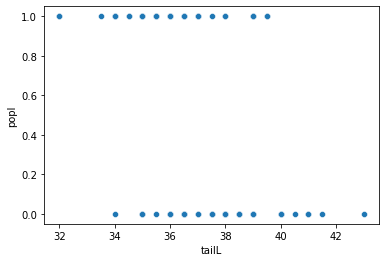

In [65]:
sns.scatterplot(x = 'tailL', y = 'popl', data = df)

Figure 4: Scatter plot of tail length and populationl

Written Answer: There doesn't seem to be a good relationship between tail length and population at all since there is really only the extremes shown on the scatter plot, either the value is at the highest or its at the lowest.

### Question 3 (10pt)
Write a function logisticRegLoss(b,D,y,name) that calculates the Loss function for the logistic regression (negative log-likelihood, see lecture). The function should call logisticRegPredict to get the prediction, and then calculate the Loss and the derivative of the loss in respect to all regression paramaters. The function should be able to use multiple regressors (like multRegLossRSS from previous homeworks).    

Report the negative log likelihood (and derivates) for a logistic regression model that predicts popI as a function of tailL: 
- for the parameter values [0,0]
- for the parameter values [17.5,-0.5]
- for the parameter values [25.56,-0.7]

Which one is the best parameter setting of the three? 

In [83]:
def logisticRegLoss(b, D, y, xname):
    p = logisticRegPredict(b, D, xname)
    loss = -sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    N = len(xname)
    grad = np.zeros(N + 1)
    res = y - p

    grad[0] = -np.sum(res)
    for i in range(N):
        grad[i + 1] = -np.sum(res * D[xname[i]])
    return (loss, grad)

#Function testing
loss, grad = logisticRegLoss([0, 0], df, df['tailL'], ['popl'])
print(f'loss: {loss}, grad: {grad}')
loss, grad = logisticRegLoss([17.5, -0.5], df, df['tailL'], ['popl'])
print(f'loss: {loss}, grad: {grad}')
loss, grad = logisticRegLoss([25.56, -0.7], df, df['tailL'], ['popl'])
print(f'loss: {loss}, grad: {grad}')

loss: 72.0873067782344, grad: [-3797. -1630.]
loss: 66531.00000336075, grad: [-3848.99999664 -1652.9999981 ]
loss: 97223.34000000119, grad: [-3849. -1653.]


Written Answer: The best parameter setting of the three is the third one since it has the highest log-likelihood.

### Question 4 (10pt)
Write a function logisticRegFit(D,y,xname,figure=True) that fits the logistic model by minimizing the above Loss function. 
- D: A data frame with the explanatory variables 
- y: A dichotomous (0 or 1) response variable 
- xname: Names of x variables to be used 
- figure: Flag (True / False) indicating if the code should produce a figure. 
When there is only one x-variable, and figure==True, then function should produce a scatter plot of the data and the predicted values. 

The function should return the log-likelihood of the data under the best model and the best fitting (maximum liklihood) estimates of b. Remember that the function value you are minimizing is the *negative* log-likelihood, and the best fitting value is stored in RES.fun

Fit a logistic regression model that predicts popI as a function of tailL. Make sure the function generates a plot. Report log-likelihood and b-values. 

In [88]:
def logisticRegFit(D, y, xname, figure = True):
    N = len(xname)
    b0=np.zeros((N+1,1))
    RES = so.minimize(logisticRegLoss,b0,args=(D,y,xname),jac=True)
    
    #The function is not coming back with a successful RES but if it did
    #then it would plot the scatterplot depending on the length of xname
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
        
    if (figure):
        if (N == 1):
            sns.scatterplot(x = xname[0], y = y, data = df)
        else:
            sns.scatterplot(x = xname[0], y = y, hue = xname[1], data = df)
    
    b = RES.fun
    res = y - np.mean(y)
    TSS = sum(res ** 2)
    RSS,deriv = logisticRegLoss(b, D, y, xname)
    R2 = 1 - RSS / TSS
    return (R2, b)

### Question 5 (10pt)
Now fit the model explaing popI from tailL and bodyL in a multiple logistic regression model. Report the log-likelihood and parameter values. Is the fit better than tailL alone? 

Also fit the model explaing popI from tailL and totalL in a multiple logistic regression model. Again, report the log-likelihood and parameter values. 

What do you observe in terms of log-likelihood and in terms of paramters? Why do these two models yield exactly the same log-liklihood? 

C:\Users\Public\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Public\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


unsuccessful fit
      fun: nan
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([  58. , 2196. , 2837.7])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 112
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([ -17.32328007, -783.87842303, -674.45303727])


TypeError: 'float' object is not subscriptable

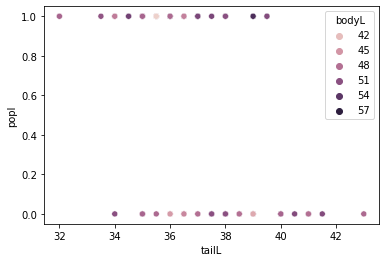

In [89]:
R2, b = logisticRegFit(df, df['popl'], ['tailL', 'bodyL']) #Issue with optimizing the function
print(f'R2: {R2}, b: {b}')
R2, b = multRegFit(df, df['popl'], ['tailL', 'bodyL'])
print(f'R2: {R2}, b: {b}')

Figure 5: Scatter plots of 'popl' explained by both 'tailL' and 'bodyL'

Written Answer: In terms of the log-likelihood we can see that they are the same, and from the parameters we can see that the third parameter from above is still the best.  The models yield the same likelihood because the relationship is very similar between the two variables.